Uncoded BPSK(8,8), Uncoded BPSK(2,2),Autoencoder(2,2),Autoencoder(8,8)

In [2]:
import sionna as sn
import tensorflow as tf

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import keras
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer,Input, Dense, GaussianNoise,Lambda,BatchNormalization
from keras import regularizers
from keras.optimizers import Adam,SGD
from keras import backend as K

In [4]:
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.linear import LinearEncoder,OSDecoder
from sionna.utils import BinarySource, ebnodb2no,sim_ber
from sionna.utils.metrics import  count_block_errors
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER

In [5]:
class Uncodedmodel(Model):
    def __init__(self,k,n,num_bits_per_symbol,demapping_method = 'app'):
        super().__init__()
        
        self.k = k
        self.n = n
        self.num_bits_per_symbol = num_bits_per_symbol
        self.source = BinarySource()
        self.constellation = Constellation("pam",self.num_bits_per_symbol)
        self.mapper = Mapper(constellation = self.constellation)
        self.demapper = Demapper(demapping_method,constellation = self.constellation)
        self.channel = AWGN()
        
    @tf.function()
    def call(self,batch_size,ebno_db):
        no = ebnodb2no(ebno_db,num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=self.k/self.n)  
        u = self.source([batch_size,self.k])
        x = self.mapper(u)
        y = self.channel([x,no])
        llr = self.demapper([y,no])
        return u,llr

In [6]:
class Encoder(Layer):
    def __init__(self,M,n):
        super().__init__()
        
        self.M = M
        self.n = n
        
        self._dense1 = Dense(self.M,'relu')
        self._dense2 = Dense(self.n, 'linear')
        self._lambda = Lambda(lambda x: np.sqrt(self.n)*K.l2_normalize(x,axis=1))
    
    def call(self,x):
        x = self._dense1(x)
        x = self._dense2(x)
        x = self._lambda(x)
        return x

In [7]:
class Decoder(Layer):
    def __init__(self,M,n):
        super().__init__()
        
        self.M = M
        self.n = n
        
        self._dense1 = Dense(self.M,'relu')
        self._dense2 = Dense(self.M, 'softmax')
    
    def call(self,y):
        y = self._dense1(y)
        y = self._dense2(y)

        return y

In [8]:
class Autoencoder(Model):
    def __init__(self, M,n,R,training):
        super().__init__()

        self.M = M
        self.n = n
        self.R = R
        
        self.training = training
        
        self.encoder = Encoder(self.M,self.n)
        self.decoder = Decoder(self.M,self.n)
        
        if self.training:
            self.cce = tf.keras.losses.CategoricalCrossentropy()

    def call(self,batch_size,ebno_db):
        
        s = np.random.randint(self.M,size=batch_size)
        s_onehot = tf.one_hot(s,depth=self.M)
        s_onehot = np.array(s_onehot)
        
        x = self.encoder(s_onehot)
        
        if self.training:
            noise = tf.random.normal(shape=tf.shape(x), stddev=1.0/(2*self.R*5.01187)**0.5)
            y = x + noise

        else:
            ebno = 10**(ebno_db/10)
            noise = tf.random.normal(shape=tf.shape(x), stddev=1.0/(2*self.R*ebno)**0.5)
            y = x + noise
        
        y = self.decoder(y)
        
        if self.training:
            loss = self.cce(s_onehot,y)
            return loss
        else:
            s_hat = np.argmax(y,axis=1)
            return s,s_hat

In [9]:
def training_22(model):
    optimizer = Adam(learning_rate=0.001)

    for i in range(epoch_22):
        with tf.GradientTape() as tape:
            loss = model(training_batch_size,ebno_db=5.01187) 
        weights = model.trainable_weights
        grads = tape.gradient(loss,weights)
        optimizer.apply_gradients(zip(grads, weights))

        if i % 100 == 0:
            print('Iteration {}/{}  CCE: {:.4f}'.format(i, epoch_22, loss.numpy()), end='\r')

In [10]:
def training_88(model):
    optimizer = Adam(learning_rate=0.001)

    for i in range(epoch_88):
        with tf.GradientTape() as tape:
            loss = model(training_batch_size,ebno_db=5.01187) 
        weights = model.trainable_weights
        grads = tape.gradient(loss,weights)
        optimizer.apply_gradients(zip(grads, weights))

        if i % 100 == 0:
            print('Iteration {}/{}  CCE: {:.4f}'.format(i, epoch_88, loss.numpy()), end='\r')

In [11]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [12]:
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

In [13]:
weights_path_ae_22  = 'ae_22_weights'
weights_path_ae_88  = 'ae_88_weights'


training_batch_size = tf.constant(30000, tf.int32) 

In [14]:
np.random.seed(1)
tf.random.set_seed(1)
epoch_22 = 3000
model_ae_22 = Autoencoder(M=4,n=2,R=1,training=True)
training_22(model_ae_22)
save_weights(model_ae_22, weights_path_ae_22)

In [15]:
epoch_88 = 1000
model_ae_88 = Autoencoder(M=256,n=8,R=1,training=True) 
training_88(model_ae_88)
save_weights(model_ae_88, weights_path_ae_88)

In [16]:
ebno_db = np.arange(-2, 10.5, 0.5) 

In [17]:
BER = {}
BLER = {}

# Uncoded BPSK(2,2) 
uncoded_sys_2_2 = Uncodedmodel(k = 2 ,n = 2, num_bits_per_symbol = 1)
ber,bler = sim_ber(uncoded_sys_2_2, ebno_db, soft_estimates=True,batch_size=10000, num_target_block_errors=2000, max_mc_iter=200)
BLER['uncoded_2_2'] = bler.numpy()
BER['uncoded_2_2'] = ber.numpy()

# Uncoded BPSK(8,8) 
uncoded_sys_8_8 = Uncodedmodel(k = 8 ,n = 8, num_bits_per_symbol = 1)
ber,bler = sim_ber(uncoded_sys_8_8, ebno_db,soft_estimates=True, batch_size=10000, num_target_block_errors=2000, max_mc_iter=200)
BLER['uncoded_8_8'] = bler.numpy()
BER['uncoded_8_8'] = ber.numpy()

# autoencoder (2,2)
model_ae_22 = Autoencoder(M=4,n=2,R=1,training=False)
load_weights(model_ae_22,weights_path_ae_22)
ber,bler = sim_ber(model_ae_22,ebno_db,batch_size=20000, num_target_bit_errors=2000, max_mc_iter=200)
BLER['ae_22'] = ber.numpy()

# autoencoder (8,8)
model_ae_88 = Autoencoder(M=256,n=8,R=1,training=False)
load_weights(model_ae_88,weights_path_ae_88)
ber,bler = sim_ber(model_ae_88,ebno_db,batch_size=80000, num_target_bit_errors=2000, max_mc_iter=200)
BLER['ae_88'] = ber.numpy()


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.0 | 1.3070e-01 | 2.4540e-01 |        2614 |       20000 |         2454 |       10000 |         1.3 |reached target block errors
     -1.5 | 1.2060e-01 | 2.2800e-01 |        2412 |       20000 |         2280 |       10000 |         0.0 |reached target block errors
     -1.0 | 1.0635e-01 | 2.0330e-01 |        2127 |       20000 |         2033 |       10000 |         0.0 |reached target block errors
     -0.5 | 9.0050e-02 | 1.7140e-01 |        3602 |       40000 |         3428 |       20000 |         0.0 |reached target block errors
      0.0 | 7.9925e-02 | 1.5300e-01 |        3197 |       40000 |         3060 |       20000 |         0.0 |reached target block errors
      0.5 | 6.5000e-02 | 1.2610e-01 |        2600 |       40000 |

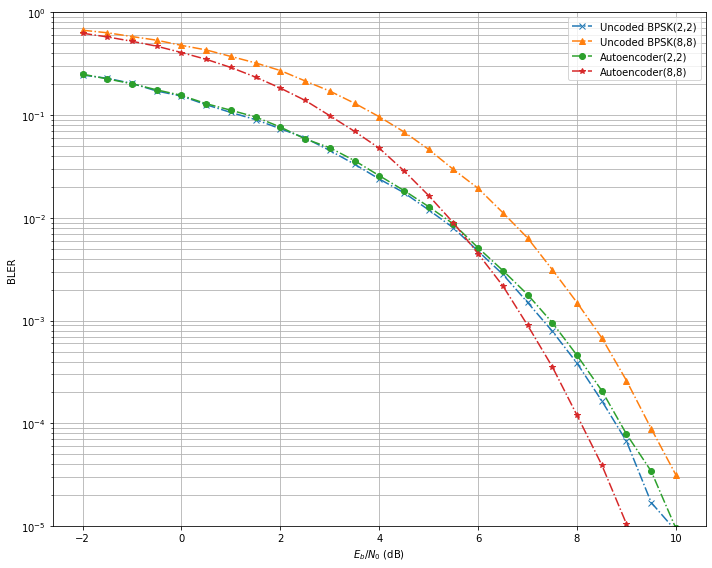

In [18]:
plt.figure(figsize=(10,8))

plt.semilogy(ebno_db, BLER['uncoded_2_2'], 'x-.', c=f'C0', label=f'Uncoded BPSK(2,2)')
plt.semilogy(ebno_db, BLER['uncoded_8_8'], '^-.', c=f'C1', label=f'Uncoded BPSK(8,8)')
plt.semilogy(ebno_db, BLER['ae_22'], 'o-.', c=f'C2', label=f'Autoencoder(2,2)')
plt.semilogy(ebno_db, BLER['ae_88'], '*-.', c=f'C3', label=f'Autoencoder(8,8)')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-5, 1.0))
plt.legend()
plt.tight_layout()